In [50]:
import os
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torchvision.models as models
from torchvision import transforms

import torchaudio

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Preprocessing word (one hot encoding)

In [2]:
class TextTransform:
    """ Maps characters to integers and vice versa """
    def __init__(self):
        char_map_str = """
            ' 0
            <SPACE> 1
            a 2
            b 3
            c 4
            d 5
            e 6
            f 7
            g 8
            h 9
            i 10
            j 11
            k 12
            l 13
            m 14
            n 15
            o 16
            p 17
            q 18
            r 19
            s 20
            t 21
            u 22
            v 23
            w 24
            x 25
            y 26
            z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence
    
    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')
    
    def tensor_to_text(self, tensor):
        word = tensor.transpose(1,0)
        output = [0]*len(word)
        for i in range(len(word)):
            for j in range(28):
                if word[i][j] == 1: output[i] = self.index_map[j]
        return ''.join(output)

    def one_hot_enc(self, word):
        """ Returns a sequence of ones and zeros, result of one hot encoding """
        word = self.text_to_int(word)
        word = Variable(torch.tensor(word))
        word = torch.nn.functional.one_hot(word, len(self.index_map))
        return word.transpose(0, 1)

### Custom dataset

* wav file => spectrogram
* word => one-hot encoded tensors (28xword_size)

In [86]:
class SpeakDataset(Dataset):
    """ Pronunced words dataset """

    def __init__(self, csv_file: str, root_dir: str, audio_transform=None, text_transform=None):
        """ Args:
            csv_file (string): path to the csv file
            root_dir (string): directory with all the audio files
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.audio_transform = audio_transform
        self.text_transform = TextTransform()
        self.data_labels = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        audio_name = os.path.join(self.root_dir, self.data_labels['filename'][idx])
        waveform, sample_rate = torchaudio.load(audio_name)
        word = self.data_labels['word'][idx]
        
        # one hot encoding word
        label = self.text_transform.one_hot_enc(word)
        
        # spectrogram
        specgram = torchaudio.transforms.MelSpectrogram()(waveform)
        specgram = F.interpolate(specgram, size=len(word), mode="nearest")

        if self.audio_transform:
            specgram = self.audio_transform(specgram)
        
        sample = { "specgram": specgram, "label": label }

        return sample

Shape of spectrogram: torch.Size([1, 2, 128, 4])
Shape of spectrogram: torch.Size([1, 2, 128, 5])
Shape of spectrogram: torch.Size([1, 2, 128, 8])


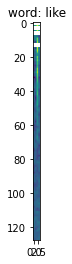

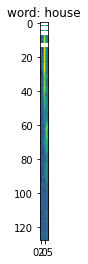

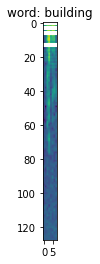

In [87]:
# testing the audio preprocessing pipeline

dataset = SpeakDataset(csv_file='data.csv', root_dir='data')
train_data = DataLoader(dataset, batch_size=1, shuffle=True)
text_transformer = TextTransform()

for idx, sample in enumerate(train_data):
    specgram = sample["specgram"]
    word = sample["label"][0]
    
    print(f"Shape of spectrogram: {specgram.size()}")
    plt.figure()
    plt.title(f"word: {text_transformer.tensor_to_text(word)}")
    p = plt.imshow(specgram.log2()[0, 0,:,:].detach().numpy())
    
    if idx > 1: break

### Audio Encoder

* Pretrained ResNet model
* Transfer learning:
    * new Linear layer
    * new fully connected layer

In [53]:
resnet_model = models.resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/achraf/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def train(model, loss_fn,
          train_loader, valid_loader,
          epochs, optimizer, train_losses,
          valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
    
    if change_lr:
        optimizer = change_lr(optimizer, epoch)
    
    for i, data in enumerate(train_loader):
        x, y = data
        optimizer.zero_grad()
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    
    for i, data in enumerate(valid_loader):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        trace_y.append(y.cpu().detach().numpy())
        trace_yhat.append(y_hat.cpu().detach().numpy())      
        batch_losses.append(loss.item())
    
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [67]:
conv = nn.Conv2d(2,1,3,stride=(1,1),padding=(1,1))
x = torch.randn([1, 2, 128, 128])

for idx, sample in enumerate(train_data):
    specgram = sample["specgram"]
    output = conv(specgram)
    output = resnet_model(output)
    print(output.size())
    
    if idx > 1: break
# resnet_model(x)

torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])


In [ ]:
class AudioEncoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, word_size: int):
        super(AudioEncoder, self).__init__()
        self.l1 = nn.Linear(in_channels, out_channels, bias=False)
        self.resnet = models.resnet18(pretrained=True)
        self.l2 = nn.Linear(out_channels, word_size, bias=False)
        resnet_model = models.resnet34(pretrained=True)
        resnet_model.fc = nn.Linear(512,50)
        resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet_model = resnet_model.to(device)
    
    def forward(input):
        output = F.gelu(self.l1(input))
        output = F.gelu(self.resnet(input))

        return F.gelu(self.l1(input))

In [ ]:
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

In [ ]:
resnet_model = models.resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]

train(resnet_model, loss_fn,
      train_loader, valid_loader,
      epochs, optimizer,
      resnet_train_losses, resnet_valid_losses,
      lr_decay)

### Self attention Encoder (Transformer)

* input: encoded audio + one-hot encoded word, concatenated (x axis being the time)

In [70]:
class SelfAttention(nn.Module):
    def __init__(self, k, heads=8):
        super(SelfAttention, self).__init__()
        self.k, self.heads = k, heads

        self.tokeys = nn.Linear(k, k*heads, bias=False)
        self.toqueries = nn.Linear(k, k*heads, bias=False)
        self.tovalues = nn.Linear(k, k*heads, bias=False)
        
        self.unifyheads = nn.Linear(heads*k, k)
    
    def forward(self, x):
        b, t, k = x.size()
        h = self.heads

        queries = self.toqueries(x).view(b, t, h, k)
        keys = self.tokeys(x).view(b,t,h,k)
        values = self.tovalues(x).view(b,t,h,k)

        keys = keys.transpose(1,2).contiguous().view(b*h,t,k)
        queries = queries.transpose(1,2).contiguous().view(b*h,t,k)
        values = values.transpose(1,2).contiguous().view(b*h,t,k)

        queries = queries / (k ** (1/4))
        keys = keys / (k ** (1/4))

        dot = torch.bmm(queries, keys.transpose(1,2))
        dot = F.softmax(dot, dim=2)
        out = torch.bmm(dot, values).view(b,h,t,k)
        out = out.transpose(1,2).contiguous().view(b,t,h*k)
        return self.unifyheads(out)

In [71]:
class TransformerBlock(nn.Module):
    def __init__(self, k, heads):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(k, heads=heads)

        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4*k),
            nn.ReLU(),
            nn.Linear(4*k, k)
        )

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended+x)
        fedforward = sef.ff(x)
        return self.norm2(fedforward+x)

In [72]:
class Transformer(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
        super(Transformer, self).__init__()
        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

        tblocks = [TransformerBlock(k=k, heads=heads) for i in range(depth)]
        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(k, num_classes)
    
    def forward(self, x):
        """
            :param x: A (b,t) tensor of integer values representing letters
            :retur,: A (b,c) tensor of log-probabilities over the classes
        """

        tokens = self.token_emb(x)
        b, t, k = tokens.size()
        positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b,t,k)

        x = tokens + positions
        x = self.tblocks(x)

        x = self.toprobs(x.mean(dim=1))
        return F.log_softmax(x, dim=1)

### Final model (putting everything together)

In [ ]:
class SpeakfluentModel(nn.Module):
    def __init__(self):
        super(SpeakfluentModel, self).__init__()
        self.audio_encoder = AudioEncoder()
        self.transformer = Transformer()
        self.conv2d = nn.Conv2d(in_channels=16,out_channels=33,kernel_size=(16,1))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, word, audio):
        word = self.audio_encoder(word)
        audio = self.audio_encoder(audio)
        # concatenate word and audio on the y axis
        output = torch.cat((word, audio), 0)
        # feed forward to the transformer
        output = self.transformer(output)
        # apply conv2d to get a 1D tensor
        output = self.conv2d(output)
        # apply softmax
        return self.softmax(output)